<a href="https://colab.research.google.com/github/relhwigi/GE_GRAPE_Mammogram_Classification/blob/main/Machine_Learning_using_GE_Mammography_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using Grammatical Evolution**
###Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

This notebook contains the implementation. For the Exploratory Data Analysis please refer to notebook xx.ipynb and for the confidence in the results please refer to notebook xx.ipynb

### **Mounting drive and cloning repos**



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Cloning FYP repo to get access to grammar

In [2]:
import os.path

PATH = '/content/drive/MyDrive/GE_GRAPE_Mammogram_Classification/'
if os.path.exists(PATH):
    print('FYP directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/relhwigi/GE_GRAPE_Mammogram_Classification.git
    print('Cloning FYP repo in your Drive')

FYP directory already exists


Cloning GRAPE repo to get access to GRAPE files

In [3]:
PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('GRAPE directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning GRAPE into your Drive')

GRAPE directory already exists


Moving into GRAPE repository

In [4]:
%cd /content/drive/MyDrive/grape/

/content/drive/MyDrive/grape


Suppressing Warnings

In [5]:
import warnings
warnings.filterwarnings("ignore")

### **Importing libraries**

In [6]:
!pip install deap==1.3 

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
import seaborn as sns

     |████████████████████████████████| 152 kB 12.6 MB/s 


### ***Preparing Data***

Loading dataset

In [7]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

Size of dataset

In [8]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

Label distribution

In [9]:
# number of positive and negative cases in dataset
label_distribution = data['Label'].value_counts()

**Preprocessing Data**

Dropping columns from smaller

In [12]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

Number of columns remaining




In [13]:
final_number_of_columns = len(data.columns)

Separating data and labels into separate np arrays

In [14]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

Oversampling the data

In [15]:
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

Splitting data into train and test sets

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print(Counter(Y_train))
print('Test (X,Y):\t', X_test.shape, Y_test.shape)
print(Counter(Y_test))

Training (X,Y):	 (33625, 104) (33625,)
Counter({1: 16813, 0: 16812})
Test (X,Y):	 (14411, 104) (14411,)
Counter({0: 7206, 1: 7205})


Get transpose of X arrays

In [17]:
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

### ***Defining Fitness Function***

In [18]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Defining Grammar***

Checking grammar file

In [19]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

Declare grammar

In [20]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Grammatical Evolution***

Setting GE parameters

In [ ]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 500
P_CROSSOVER = 0.95
P_MUTATION = 0.01
ELITE_SIZE = 1
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 16
MIN_INIT_TREE_DEPTH = 8
MAX_TREE_DEPTH = 24
MAX_WRAPS = 0
CODON_SIZE = 320

Creating DEAP toolbox

In [ ]:
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)
toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 
toolbox.register("evaluate", fitness_eval)
toolbox.register("select", ge.selTournament, tournsize=5)
toolbox.register("mate", ge.crossover_onepoint)
toolbox.register("mutate", ge.mutation_int_flip_per_codon)

Main function

In [ ]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.507724	0.0310964	0.392654	0.611509	0.389564    	562            	388.02    	1764      	0             	45.37          
1  	776    	0.502661	0.0274785	0.392654	0.59081 	0.593991    	515            	433.433   	1530      	0.010083      	25.2703        
2  	101    	0.508608	0.0287326	0.385398	0.622959	0.631323    	778            	336.194   	1363      	0.0105844     	26.5363        
3  	52     	0.510721	0.0293827	0.385398	0.622959	0.631323    	778            	353.458   	1418      	0.0102196     	27.6012        
4  	63     	0.512943	0.0324543	0.385398	0.623822	0.627784    	426            	378.72    	1442      	0.0121992     	27.8479        
5  	40     	0.51434 	0.0327437	0.385398	0.623822	0.627784    	426            	382.678   	1357      	0.0114021     	27.111         
6  	27     	0.512998	0.033853 	0.385398	0.611717	0.627784    	426            	390.7

Statistics

In [ ]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.507724,0.031096,0.392654,0.611509,0.389564,562,388.020,1764,0.000000,45.369980
1,1,776,0.502661,0.027479,0.392654,0.590810,0.593991,515,433.433,1530,0.010083,25.270323
2,2,101,0.508608,0.028733,0.385398,0.622959,0.631323,778,336.194,1363,0.010584,26.536300
3,3,52,0.510721,0.029383,0.385398,0.622959,0.631323,778,353.458,1418,0.010220,27.601223
4,4,63,0.512943,0.032454,0.385398,0.623822,0.627784,426,378.720,1442,0.012199,27.847856
5,5,40,0.514340,0.032744,0.385398,0.623822,0.627784,426,382.678,1357,0.011402,27.110983
6,6,27,0.512998,0.033853,0.385398,0.611717,0.627784,426,390.746,1374,0.010505,26.935397
7,7,18,0.516110,0.036549,0.368743,0.622424,0.627784,426,393.555,1387,0.009735,26.500358
8,8,20,0.517148,0.036486,0.368743,0.629532,0.633613,49,400.604,1444,0.010360,25.907864
9,9,19,0.517100,0.039227,0.368743,0.637294,0.641316,168,417.966,1463,0.011379,25.741931


Best individual

In [ ]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
sub(sub(x[72],sub(92.52,x[44])),neg(pdiv(pdiv(x[44],75.59),pdiv(mul(x[39],pdiv(x[44],neg(pdiv(pdiv(x[44],24.96),28.24)))),x[33]))))

Training Fitness:  0.6672713754646841

Depth:  12

Length of the genome:  751

Used portion of the genome: 0.05



### ***Testing Best Individual***

Calculating predictions

In [22]:
predictions = sub(sub(X_test[72],sub(92.52,X_test[44])),neg(pdiv(pdiv(X_test[44],75.59),pdiv(mul(X_test[39],pdiv(X_test[44],neg(pdiv(pdiv(X_test[44],24.96),28.24)))),X_test[33]))))

In [23]:
print(predictions)

[-90.47332023  48.51138004  26.97974368 ... -29.42362592 113.53754919
  32.65278018]


Getting prediction class

In [24]:
Y_prediction_class = [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]

In [28]:
print(Counter(Y_prediction_class))

Counter({1: 9192, 0: 5219})


Calculating the Confusion Matrix

In [29]:
TP, FN, TN, FP = 0, 0, 0, 0
for x, y in zip(Y_test, Y_prediction_class):
  if x == 0:
    if y == 0:
      TN = TN + 1
    else:
      FP = FP + 1
  elif x == 1:
    if y == 1:
      TP = TP + 1
    else:
      FN = FN + 1

Calculating Accuracy

In [30]:
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
accuracy

0.6640760530150579

Calculating True Positive Rate

In [31]:
TPR = TP/(TP+FN)
TPR

0.8019430950728661

Calculating True Negative Rate

In [32]:
TNR = TN/(TN+FP)
TNR

0.5262281432139884

Calculating False Positive Rate

In [33]:
FPR = FP/(FP+TN)
FPR

0.47377185678601164

Calculating False Negative Rate

In [34]:
FNR = FN/(FN+TP)
FNR

0.19805690492713393

Calculating Area under the curve

In [35]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
auc

0.6640856191434272

### ***Plotting Results***

Best individuals plots

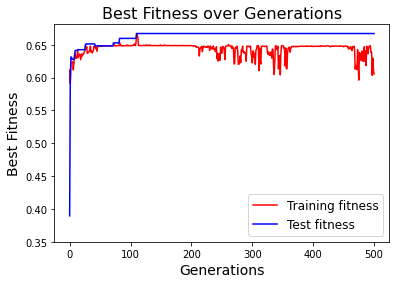

In [ ]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

Average fitness plot

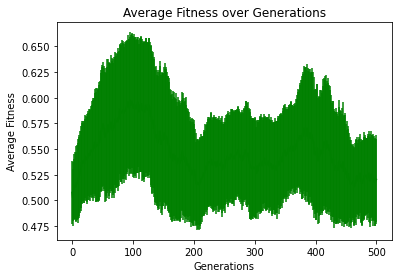

In [ ]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Genome length plots

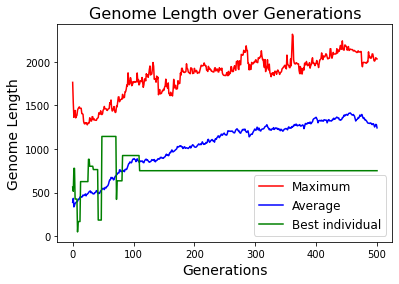

In [ ]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()